# Decision Trees and XGBoost
#### Holden Bruce

Goal of this problem: predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

In [1]:
import pandas as pd
carseats = pd.read_csv('carseats.csv')
carseats.head() #print first 5 

import numpy as np # calculate the mean and standard deviation
import matplotlib.pyplot as plt # to draw graphs
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import DecisionTreeRegressor # to build a regression tree
from sklearn.tree import plot_tree # to draw a classification tree
import graphviz
from sklearn.tree import export_graphviz # to export a tree using graphviz
#conda install -c conda-forge xgboost
import xgboost as xgb # XGBoost 
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import mean_squared_error # calculates mse
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,GradientBoostingClassifier

In [2]:
#split carseats data into X and y
X = carseats.drop('Sales',axis=1)
#X.head()
y = carseats['Sales']
#y.head()

Now that we have created X, which has the data we want to use to make predictions, and y, which has the data we want to predict, we are ready to continue formatting X so that it is suitable for making a model with XGBoost.

#### Identifying missing data
XGBoost can handle missing data but i need to set all missing values to 0


In [3]:
### one-hot encoding 
X.dtypes
carseats.info() #get info on variables, looking for dtypes, could also use .dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   400 non-null    int64  
 1   Sales        400 non-null    float64
 2   CompPrice    400 non-null    int64  
 3   Income       400 non-null    int64  
 4   Advertising  400 non-null    int64  
 5   Population   400 non-null    int64  
 6   Price        400 non-null    int64  
 7   ShelveLoc    400 non-null    object 
 8   Age          400 non-null    int64  
 9   Education    400 non-null    int64  
 10  Urban        400 non-null    object 
 11  US           400 non-null    object 
dtypes: float64(1), int64(8), object(3)
memory usage: 37.6+ KB


In [4]:
#check the variables of type object
X.ShelveLoc.unique() #array(['Bad', 'Good', 'Medium'], dtype=object)
X.Urban.unique() #array(['Yes', 'No'], dtype=object)
X.US.unique() #array(['Yes', 'No'], dtype=object)

array(['Yes', 'No'], dtype=object)

XGBoost natively supports continuous data but does not natively support categorical data...so in order to use categorical data with XGBoost, we have to convert the columns of categorical data into multiple columns of binary values (one-hot encoding). <br><br>
Reasoning: if we convert the categories bad/good/medium into 2/1/0, XGBoost Tree would be more likely to cluster 2 and 1 together than it would 2 and 0, since it would interpret 2&1 as being more similar than 2&0 in reality, we know that this coupling would be arbitrary / erronious so we use one-hot encoding to avoid this scenario.

In [20]:
X.ShelveLoc

pd.get_dummies(X, columns=['ShelveLoc']).head()

X_encoded = pd.get_dummies(X, columns=['ShelveLoc',
                                       'Urban',
                                       'US'])
X_encoded.head()

,Unnamed: 0,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,1,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,2,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,3,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,4,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,5,141,64,3,340,128,38,13,1,0,0,0,1,1,0


In [21]:
# X_encoded.ShelveLoc.unique() 
#AttributeError: 'DataFrame' object has no attribute 'ShelveLoc'
# X.ShelveLoc.unique()
X_encoded.columns #ShelveLoc now ShelveLoc_Bad,ShelveLoc_Good, ShelveLoc_Medium
X_encoded = X_encoded.drop('Unnamed: 0',axis=1)

#y.unique()

## (a) 
Split the data set into a training set and a test set. 

In [23]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.75, random_state=313)

## (b) 
Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [24]:
## create a decision tree and fit it to the training data
# carseats_dtree = DecisionTreeClassifier(random_state=313)
# carseats_dtree = carseats_dtree.fit(X_train, y_train)
# ValueError: Unknown label type: 'continuous'
#this is a regression problem, not a classification problem
#the y is continuous variable ... y.unique() shows an array of floats
carseats_dtree = DecisionTreeRegressor(random_state=313)
carseats_dtree = carseats_dtree.fit(X_train, y_train)

In [25]:
y_pred = carseats_dtree.predict(X_test)
mean_squared_error(y_test, y_pred) #6.307741999999999

6.307741999999999

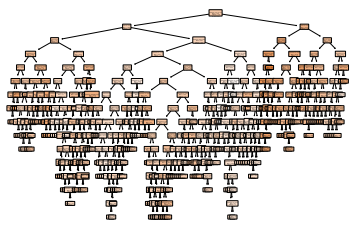

In [26]:
## plot the tree
plot_tree(carseats_dtree, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X_encoded.columns); 
### this tree is huge and almost impossible to read
### graphviz might be better here:

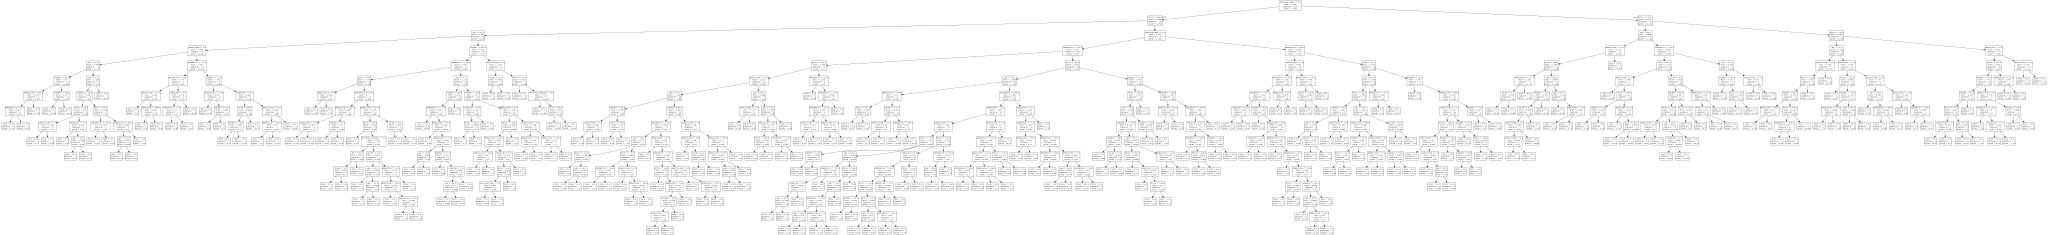

In [27]:
carseats_data = export_graphviz(carseats_dtree, out_file=None, feature_names=X_train.columns)
graphviz.Source(carseats_data)
#this graph shows us that ShelveLoc_Good is the most important predictor (root node = ShelveLoc_Good<=0.5)
#mse=7.949
#samples=300
#value=7.465

## (c)
Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

### Visualizing alpha
This massive decision trees is overfit to the training data. Max_depth and min_samples are designed to reduce overfitting, but pruning a tree with cost complexity pruning can simplify the process
of finding a smaller tree that improves the accuracy with the test data. First, I will use max_depth to find a better tree size, then I will use cost complexity pruning.

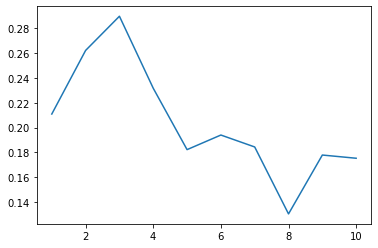

In [28]:
depth = []
for i in range(1,11):
    cv_tree = DecisionTreeRegressor(max_depth=i)
    scores  = cross_val_score(estimator=cv_tree, X=X_train, y=y_train, cv=10) # 10-fold CV
    depth.append(scores.mean())
plt.plot(range(1,11), depth)  

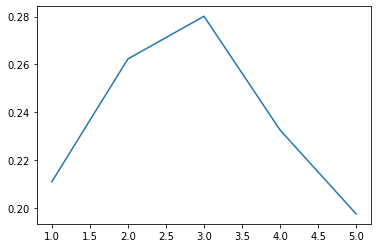

In [29]:
#now try with 5, since peak seems to be before 5
depth = []  
for i in range(1,6):
    cv_tree = DecisionTreeRegressor(max_depth=i)
    scores  = cross_val_score(estimator=cv_tree, X=X_train, y=y_train, cv=10) # 10-fold CV
    depth.append(scores.mean())
plt.plot(range(1,6), depth)    

In [30]:
pruned_tree_carseats = DecisionTreeRegressor(max_depth=depth.index(max(depth))+1)
pruned_tree_carseats.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [32]:
y_pred = pruned_tree_carseats.predict(X_test)
mean_squared_error(y_test, y_pred) #4.868775365567585

4.868775365567585

There is a reduction of MSE in the pruned tree.

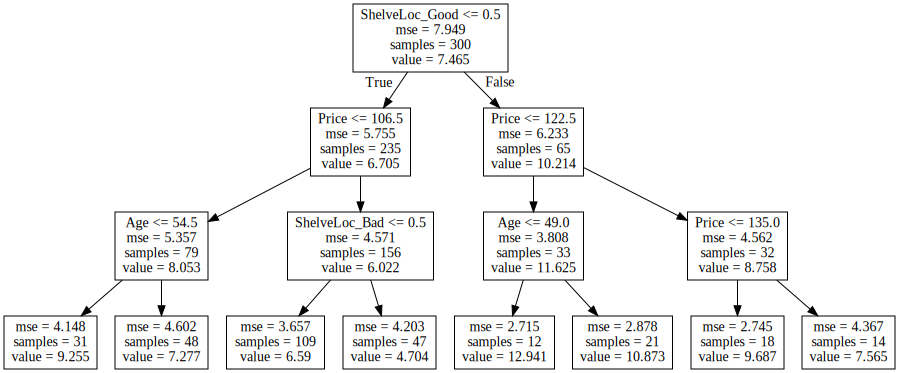

In [33]:
dot_data = export_graphviz(pruned_tree_carseats, out_file=None, feature_names=X_train.columns)
graphviz.Source(dot_data)

Pruning a decision tree is all about finding the right value for the pruning parameter, alpha, which controls how little or how much pruning occurs. Plotting the accuracy of the tree as a function of different values is one way to find the optimal value for alpha. Here I show this for both the train and test data by first extracting the different values of alpha that are available for the tree and then building a pruned tree for each value of alpha. I'm omitting the maximum value for alpha because that would prune all of the leaves, leaving only the root node.

In [34]:
path = carseats_dtree.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha

In [35]:
dtrees_array = [] # create an array that we will put decision trees into

## now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
    carseats_dtree = DecisionTreeRegressor(random_state=313, ccp_alpha=ccp_alpha)
    carseats_dtree.fit(X_train, y_train)
    dtrees_array.append(carseats_dtree)

Now let's graph the accuracy of the trees using the Training Dataset and the Testing Dataset as a function of alpha.

In [37]:
train_scores = [carseats_dtree.score(X_train, y_train) for carseats_dtree in dtrees_array]
test_scores = [carseats_dtree.score(X_test, y_test) for carseats_dtree in dtrees_array]

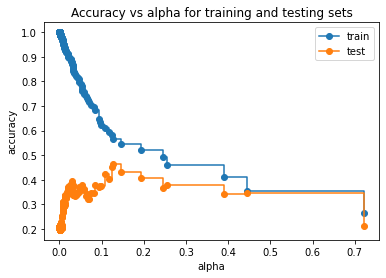

In [38]:
#plot it
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

From this graph we can see that the accuracy for the test data hits its maximum value when alpha is about 0.13...after around 0.15 the accuracy of both the test and train data drop off at about the same rate until converging around 0.45 alpha.

There are many ways we could have divided the original dataset into train and test splits. I used train_test_split initially, but how do we know I used the best training and testing data? 
<br><br>
This question can be answered with 10-fold cross validation.
<br><br>
Cross validation: finding the best alpha for cost complexity pruning. The graph above suggested that the optimal alpha is around 0.13...but maybe another set of train/test data would suggest a different optimal alpha.

In [39]:
clf_dt = DecisionTreeRegressor(random_state=313, ccp_alpha=0.13) # create the tree with ccp_alpha=0.13

Now use 5-fold cross validation to create 5 different training and testing datasets that are then used to train and test the tree. We use 5-fold because our dataset is relatively small.

<AxesSubplot:xlabel='tree'>

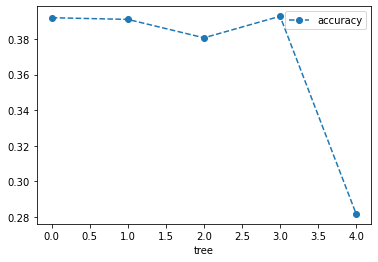

In [40]:
scores = cross_val_score(clf_dt, X_train, y_train, cv=5) 
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

This plot shows us that using different training and testing data with the same alpha results in different accuracies (dotted blue line), which suggests that alpha is sensitive to datasets. Thus, we need to make sure to pick the best train and test data. So, instead of picking a single train and test dataset, we will use cross validation to find the optimal value for ccp_alpha. 

In [42]:
#create an array to store the results of each fold during cross validiation
alpha_loop_values = []

For each candidate value for alpha, we will run 5-fold cross validation. Then we will store the mean and standard deviation of the scores (the accuracy) for each call to cross_val_score in alpha_loop_values

In [43]:
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeRegressor(random_state=313, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

#len(alpha_loop_values)

287

Now we can draw a graph of the means and standard deviations of the scores for each candidate value for alpha.

<AxesSubplot:xlabel='alpha'>

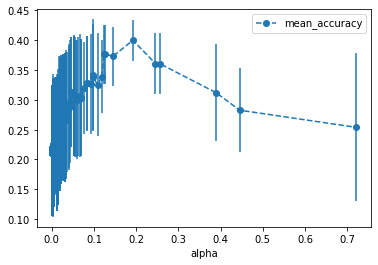

In [44]:
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                   y='mean_accuracy', 
                   yerr='std', 
                   marker='o', 
                   linestyle='--')

This graph shows us instead of setting ccp_alpha equal to 0.13, we should set it closer to 0.2...thanks cross validation! By giving a range around my 0.2 estimation, we can find the exact value of our optimal alpha this way:

In [45]:
alpha_results[(alpha_results['alpha'] > 0.19)
              &
              (alpha_results['alpha'] < 0.21)]

,alpha,mean_accuracy,std
281,0.192201,0.399734,0.034075


Now we can store the ideal value for alpha so that we can use it to build the best tree.

In [46]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.19)
              &
              (alpha_results['alpha'] < 0.21)]['alpha']
ideal_ccp_alpha
#ideal_ccp_alpha is currently stored as a series, with index=281 and 
#corresponding value=0.192201

281    0.192201
Name: alpha, dtype: float64

In [48]:
## convert ideal_ccp_alpha from a series to a float
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.1922009533730339

Now we have the ideal value for alpha and we can build, evaluate, and draw the final regression tree. Now I will build and train a new decision tree, but this time using the optimal value for alpha.

In [50]:
clf_dt_pruned = DecisionTreeRegressor(random_state=313, 
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train) 

y_pred = clf_dt_pruned.predict(X_test)
mean_squared_error(y_test, y_pred) 

4.7378562196962175

4.7378562196962175 as opposed to the 4.868775365567585 calculated from max_depth. This is a very slight reduction of MSE in the pruned tree. Possibly inconsequential. 

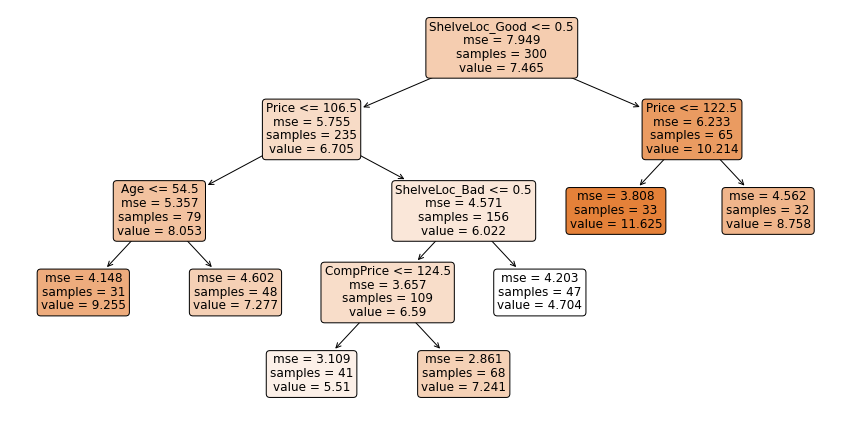

In [51]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X_encoded.columns); 
#ShelveLoc_Good <= 0.5 ... same
#mse=7.949 ... same
#samples=300 ... same (how many samples are in the root node)
#value=7.465 ... same 

## (d) 
Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.

In [52]:
### bagging is simply a special case of a random forest with m=p

carseats.shape
X_train.shape #(300, 14)

(300, 14)

In [54]:
# The argument max_features=X_train.shape[1] indicates that all 13 
# predictors should be considered for each split of the tree -- in 
# other words, that bagging should be done. 
bagged_carseats = RandomForestRegressor(max_features=X_train.shape[1],random_state=313)
bagged_carseats.fit(X_train, y_train)
# How well does this bagged model perform on the test set?
pred = bagged_carseats.predict(X_test)

Text(0, 0.5, 'y_test')

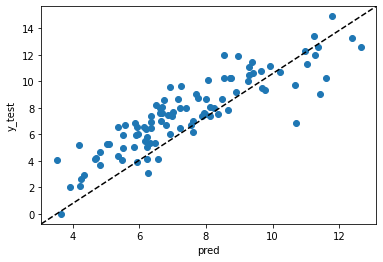

In [55]:
#plot
plt.scatter(pred,
            y_test,
            label='Sales')
plt.plot([0,1],
         [0,1],
         '--k',
         transform = plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [57]:
# MSE:
mse_bagged_carseats = mean_squared_error(y_test, pred) #1.9540108011999997
print(mse_bagged_carseats)

1.9540108011999997


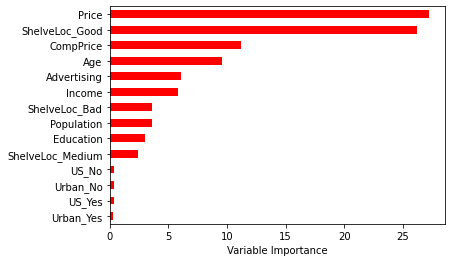

In [60]:
# Using the feature_importances_ attribute of the RandomForestRegressor,
# we can view the importance of each variable:
Importance = pd.DataFrame({'Importance':bagged_carseats.feature_importances_*100}, 
                          index = X_train.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

Most important: Price, ShelveLoc_Good 

## (e) 
Use random forests to analyze this data. What test MSE do you obtain? 
Use the importance() function to determine which variables are most 
important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [61]:
mse = np.zeros(10)
for i in range(0,10):
    random_forest_carseats = RandomForestRegressor(max_features=i+1, random_state=313)
    random_forest_carseats.fit(X_train, y_train)
    y_pred  = random_forest_carseats.predict(X_test)
    mse[i] = mean_squared_error(y_test, y_pred)

Text(0, 0.5, 'Test MSE')

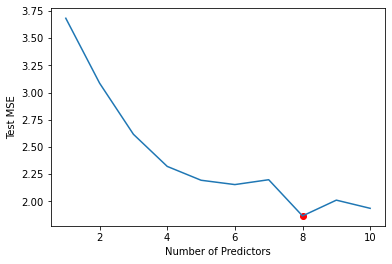

In [62]:
plt.plot(range(1,11), mse)
plt.scatter(mse.argmin()+1, min(mse), color='r')
plt.xlabel('Number of Predictors')   
plt.ylabel('Test MSE')

Optimal number of predictors is 8

In [63]:
print(mse)

[3.6840155  3.08678662 2.61692327 2.32156031 2.19435337 2.15450223
 2.19921746 1.86638295 2.01144775 1.93621938]


The Test MSE trend down as the number of predictors increases 

In [64]:
#now re-run this regression with the new optimal number of 
#predictors in max_features
random_forest_carseats = RandomForestRegressor(max_features=mse.argmin()+1, random_state=313)
random_forest_carseats.fit(X_train, y_train)
y_pred = random_forest_carseats.predict(X_test)
mse = mean_squared_error(y_test,y_pred) #1.8663829531999994

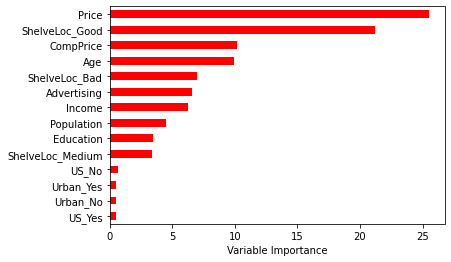

In [65]:
# Using the feature_importances_ attribute of the RandomForestRegressor,
# we can view the importance of each variable:
Importance = pd.DataFrame({'Importance':random_forest_carseats.feature_importances_*100}, 
                          index = X_train.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

Most important: Price, ShelveLoc_Good 